# Check ERA5 download domain code
ERA5 data is available at discrete grid points. The workflow assumes that the representative area covered by a given ERA5 coordinate (i.e. a grid point) extends 0.125 degrees latitude/longitude in each cardinal direction. The ERA5 download scripts therefore modify the spatial coordinates specify in the control file to account for the representative area of each ERA5 grid point. This script visualizes the ERA5 download coordinates, the area they are representative of and the actual extent of the catchment shapefile.

See: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference#ERA5:Whatisthespatialreference-Visualisationofregularlat/londata

In [1]:
import math
import numpy as np
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from shapely.geometry import Polygon

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    for line in open(file):
        
        # ... find the line with the requested setting
        if setting in line and not line.startswith('#'):
            break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
    
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [6]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'era5_download_coordinates_check.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Get the catchment shapefile

In [7]:
# Find name and location of catchment shapefile
shp_path = read_from_control(controlFolder/controlFile, 'catchment_shp_path')
shp_name = read_from_control(controlFolder/controlFile, 'catchment_shp_name')

In [8]:
# Specify default path if needed
if shp_path == 'default':
    shp_path = make_default_path('shapefiles/catchment')
else:
    shp_path = Path(shp_path)

In [9]:
# Open the shapefile
shp = gpd.read_file(shp_path/shp_name)

#### Reproduce the ERA5 download code

In [10]:
# function to round coordinates of a bounding box to ERA5s 0.25 degree resolution
def round_coords_to_ERA5(coords):
    
    '''Assumes coodinates are an array: [lon_min,lat_min,lon_max,lat_max].
    Returns separate lat and lon vectors.'''
    
    # Extract values
    lon = [coords[1],coords[3]]
    lat = [coords[2],coords[0]]
    
    # Round to ERA5 0.25 degree resolution
    rounded_lon = [math.floor(lon[0]*4)/4, math.ceil(lon[1]*4)/4]
    rounded_lat = [math.floor(lat[0]*4)/4, math.ceil(lat[1]*4)/4]
    
    # Find if we are still in the representative area of a different ERA5 grid cell
    if lat[0] > rounded_lat[0]+0.125:
        rounded_lat[0] += 0.25
    if lon[0] > rounded_lon[0]+0.125:
        rounded_lon[0] += 0.25
    if lat[1] < rounded_lat[1]-0.125:
        rounded_lat[1] -= 0.25
    if lon[1] < rounded_lon[1]-0.125:
        rounded_lon[1] -= 0.25
    
    # Make a download string
    dl_string = '{}/{}/{}/{}'.format(rounded_lat[1],rounded_lon[0],rounded_lat[0],rounded_lon[1])
    
    return dl_string, rounded_lat, rounded_lon

In [11]:
# Find the spatial extent the data needs to cover
bounding_box = read_from_control(controlFolder/controlFile,'forcing_raw_space') 

In [12]:
# Convert string to array
bounding_box = bounding_box.split('/')
bounding_box = [float(value) for value in bounding_box]

In [13]:
# Find the rounded bounding box
coordinates, lat, lon = round_coords_to_ERA5(bounding_box)

In [14]:
# Print in ERA5 format
print('ERA5 coordinates defined as [{}].'.format(coordinates))

ERA5 coordinates defined as [51.75/-116.5/51.0/-115.5].


#### Visualize

In [15]:
# Bounding box as specified in control file
bb_control_lat = [bounding_box[0],bounding_box[0],bounding_box[2],bounding_box[2],bounding_box[0]]
bb_control_lon = [bounding_box[1],bounding_box[3],bounding_box[3],bounding_box[1],bounding_box[1]]

In [16]:
# ERA5 grid points from coordinates
spacing = 0.25
points_lat = np.arange(lat[0],lat[1]+spacing,spacing).tolist()
points_lon = np.arange(lon[0],lon[1]+spacing,spacing).tolist()

# Define a plotting grid
grid_lon_era5_points, grid_lat_era5_points = np.meshgrid(points_lon,points_lat)

In [17]:
# Grid cells we assume each ERA5 point is representative of
cells_lat = np.arange(lat[0]-spacing/2,lat[1]+spacing+spacing/2,spacing).tolist()
cells_lon = np.arange(lon[0]-spacing/2,lon[1]+spacing+spacing/2,spacing).tolist()

# Define a plotting grid
grid_lon_era5_cells, grid_lat_era5_cells = np.meshgrid(cells_lon,cells_lat)

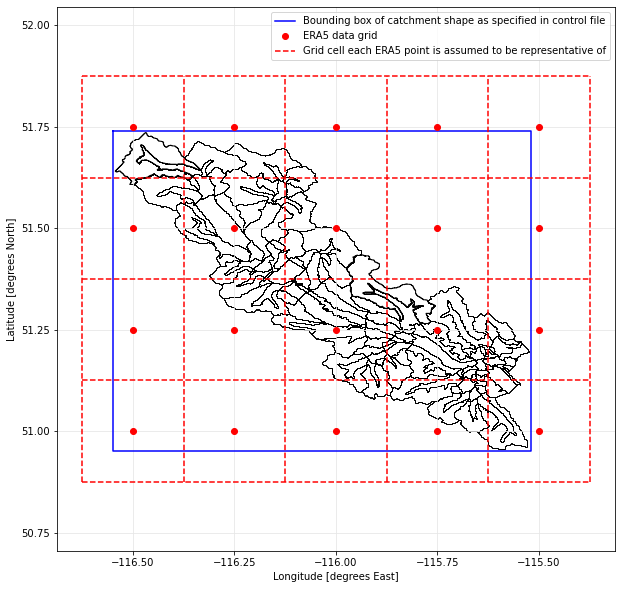

In [20]:
# Make a figure
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

# data
shp.plot(ax=ax,facecolor='None',edgecolor='k'); # catchment
plt.plot(bb_control_lon,bb_control_lat, \
         color='b', label='Bounding box of catchment shape as specified in control file') # bounding box
plt.plot(grid_lon_era5_points, grid_lat_era5_points, \
         marker='o', color='r', linestyle='none', label='ERA5 data grid') # ERA5 grid points
plt.plot(grid_lon_era5_cells, grid_lat_era5_cells, \
         color='r', linestyle='--', label='Grid cell each ERA5 point is assumed to be representative of') # ERA5 grid cells (vertical)
plt.plot(np.transpose(grid_lon_era5_cells), np.transpose(grid_lat_era5_cells), \
         color='r', linestyle='--') # ERA5 grid cells (horizontal)

# grid spacing indicating ERA5 grid points
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.25))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.25))
ax.grid(which='major', axis='both', linestyle='-', color=[0.9,0.9,0.9])
ax.axis('equal')

# fix up a legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k:v for k,v in zip(labels, handles)}
plt.legend(temp.values(), temp.keys(), loc='best')

# labels
ax.set_xlabel('Longitude [degrees East]');
ax.set_ylabel('Latitude [degrees North]');

# save
plt.savefig(fig_path/fig_name, bbox_inches='tight')